## Description
This notebook will demonstrate how to load DEA Fractional Cover using Digital Earth Australia. 
Topics covered include:

1. Inspecting the products and measurements available in the datacube
2. Loading DEA Fractional Cover for an example location
3. Plotting fractional cover as false colour images
4. Inspecting unmixing error outputs
4. Masking out missing or invalid data and unclear or wet pixels, and using this to track percentages of green and brown vegetation and bare soil over time

***

In [1]:
import datacube
from datacube.utils import masking
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import rgb, plot_wo


In [2]:
dc = datacube.Datacube(app='DEA_Fractional_Cover')

In [3]:
# List DEA Fractional Cover products available in DEA
dc_products = dc.list_products()
dc_products.loc[['ga_ls_fc_3']]

name                                        description  \
name                                                                        
ga_ls_fc_3  ga_ls_fc_3  Geoscience Australia Landsat Fractional Cover ...   

              license default_crs default_resolution  
name                                                  
ga_ls_fc_3  CC-BY-4.0        None               None

In [4]:
dc_measurements = dc.list_measurements()
dc_measurements.loc[['ga_ls_fc_3']]

name  dtype    units nodata      aliases  \
product    measurement                                            
ga_ls_fc_3 bs            bs  uint8  percent    255       [bare]   
           pv            pv  uint8  percent    255  [green_veg]   
           npv          npv  uint8  percent    255   [dead_veg]   
           ue            ue  uint8        1    255        [err]   

                       flags_definition  
product    measurement                   
ga_ls_fc_3 bs                       NaN  
           pv                       NaN  
           npv                      NaN  
           ue                       NaN

## Loading data
Now that we know what products and measurements are available for the products, we can load data from Digital Earth Australia for an example location:

In [5]:
# connect to datacube

dc = datacube.Datacube(app="07_Parallel_processing_with_Dask")

In [6]:
#Enable Dask
from dea_tools.dask import create_local_dask_cluster
client = create_local_dask_cluster(return_client=True)

<Client: 'tcp://127.0.0.1:38437' processes=1 threads=2, memory=12.21 GiB>

In [7]:
# Set up a region to load data


# Load DEA Fractional Cover data from the datacube


fc = dc.load(product='ga_ls_fc_3',
             measurements=['bs', 'pv', 'npv', 'ue'],
             output_crs='EPSG:3577',
             y=(-36.210, -36.121),
             x=(150.002, 149.884),
             time=('2019-12-11', '2020-02-10'),
             dask_chunks={"time": 1, "x": 2048, "y": 2048})


In [8]:
fc

<xarray.Dataset>
Dimensions:      (time: 15, y: 376, x: 398)
Coordinates:
  * time         (time) datetime64[ns] 2019-12-15T23:50:59.384362 ... 2020-02...
  * y            (y) float64 -4.059e+06 -4.059e+06 ... -4.07e+06 -4.07e+06
  * x            (x) float64 1.604e+06 1.604e+06 ... 1.616e+06 1.616e+06
    spatial_ref  int32 3577
Data variables:
    bs           (time, y, x) uint8 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
    pv           (time, y, x) uint8 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
    npv          (time, y, x) uint8 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
    ue           (time, y, x) uint8 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

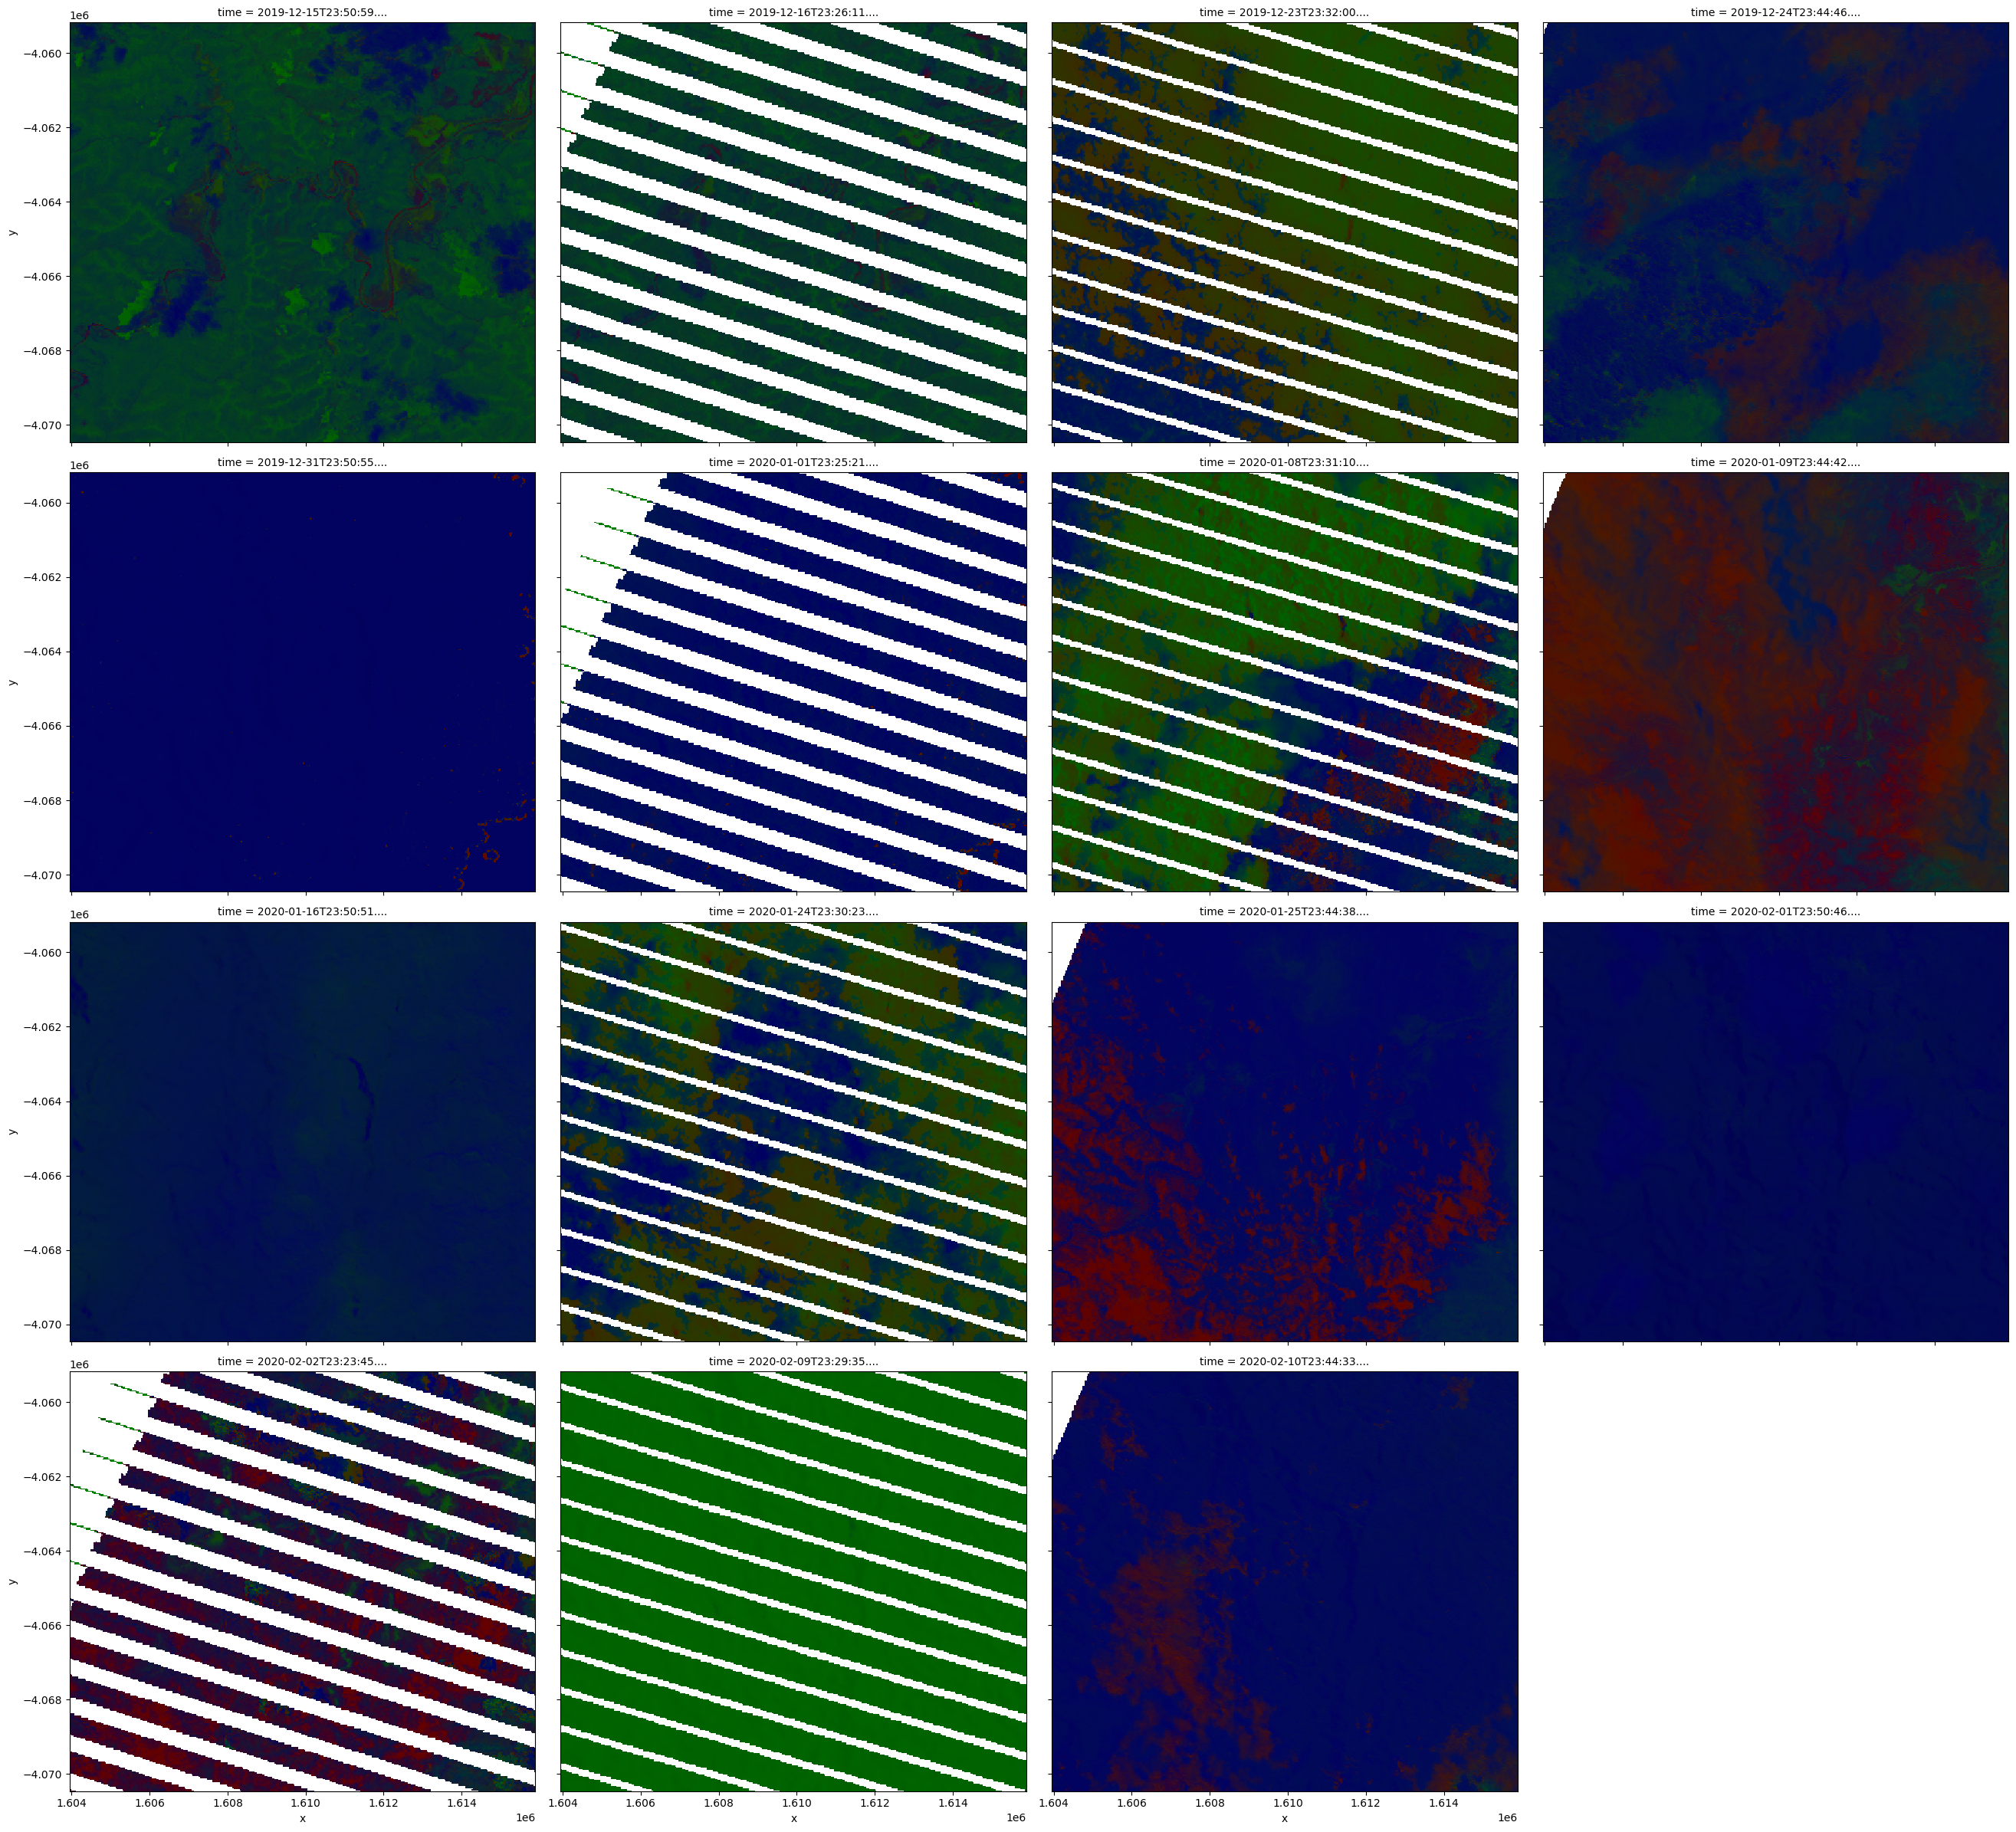

In [9]:
# Plot DEA Fractional Cover data as a false colour RGB image
rgb(fc, bands=['bs', 'pv', 'npv'], col='time')

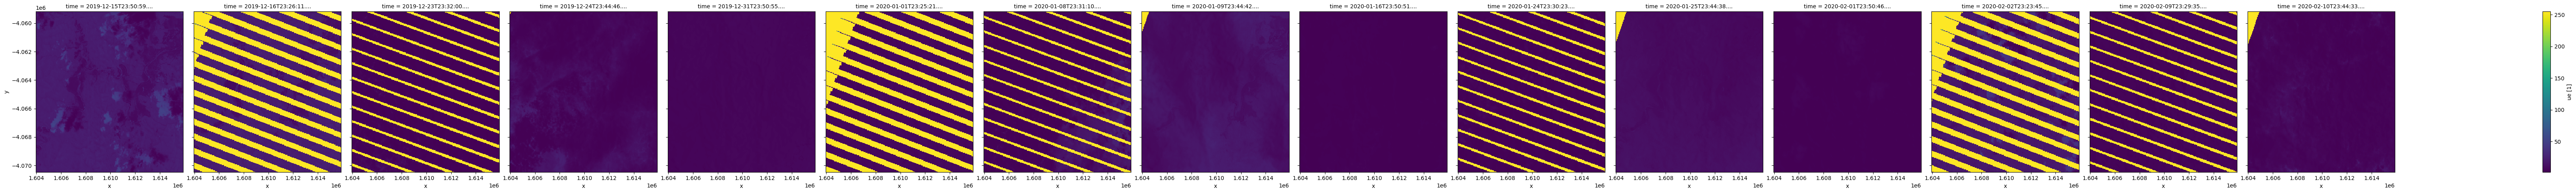

In [10]:
# Plot unmixing error using `robust=True` to drop outliers and improve contrast
fc.ue.plot(col='time', robust=True, size=5)

> **Note:** For more technical information about the accuracy and limitations of DEA Fractional Cover, refer to the Details tab of the official [Geoscience Australia DEA Fractional Cover product description](https://cmi.ga.gov.au/data-products/dea/629/dea-fractional-cover-landsat#details).

In [11]:
# Replace all nodata values with `NaN`
fc = masking.mask_invalid_data(fc)

In [12]:
def wofs_fuser(dest, src):
    """
    Fuse two WOfS water measurements represented as ``ndarray``s.

    Note: this is a copy of the function located here:
    https://github.com/GeoscienceAustralia/digitalearthau/blob/develop/digitalearthau/utils.py
    """
    empty = (dest & 1).astype(bool)
    both = ~empty & ~((src & 1).astype(bool))
    dest[empty] = src[empty]


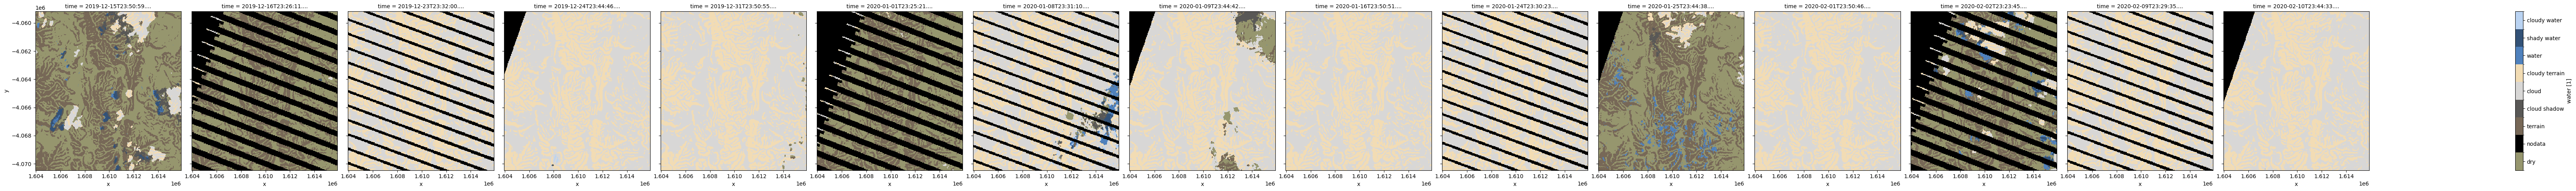

In [13]:
# Load DEA Water Observations data from the datacube
wo = dc.load(product='ga_ls_wo_3',
             group_by='solar_day',
             fuse_func=wofs_fuser,
             like=fc)

# Plot the loaded water observations
plot_wo(wo.water, col='time', size=5)

In [14]:
# Keeping only dry, non-cloudy pixels
wo_mask = masking.make_mask(wo.water, dry=True)
#wo_mask.plot(col='time', size=5)

Using this mask, we can now remove any wet and unclear pixels from our original DEA Fractional Cover data. 
Note that these pixels now appear white as they have been replaced with `NaN`.

In [15]:
# Set any unclear or wet pixel to `NaN`
fc_masked = fc.where(wo_mask)

# Plot the masked fractional cover data
#rgb(fc_masked, bands=['bs', 'pv', 'npv'], col='time')

#the error below needs the same treatment as above np.uint 8 needs replacing with uint8

In [16]:
# Calculate the percent of nodata pixels in each observation
percent_nodata = fc_masked.pv.isnull().mean(dim=['x', 'y'])

# Use this to filter to observations with less than 50% nodata
fc_masked = fc_masked.sel(time=percent_nodata < 0.75)

# The data now contains only three observations
fc_masked

<xarray.Dataset>
Dimensions:      (time: 5, y: 376, x: 398)
Coordinates:
  * time         (time) datetime64[ns] 2019-12-15T23:50:59.384362 ... 2020-02...
  * y            (y) float64 -4.059e+06 -4.059e+06 ... -4.07e+06 -4.07e+06
  * x            (x) float64 1.604e+06 1.604e+06 ... 1.616e+06 1.616e+06
    spatial_ref  int32 3577
Data variables:
    bs           (time, y, x) float64 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
    pv           (time, y, x) float64 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
    npv          (time, y, x) float64 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
    ue           (time, y, x) float64 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [22]:
print (fc_masked)


<xarray.Dataset>
Dimensions:      (time: 5, y: 376, x: 398)
Coordinates:
  * time         (time) datetime64[ns] 2019-12-15T23:50:59.384362 ... 2020-02...
  * y            (y) float64 -4.059e+06 -4.059e+06 ... -4.07e+06 -4.07e+06
  * x            (x) float64 1.604e+06 1.604e+06 ... 1.616e+06 1.616e+06
    spatial_ref  int32 3577
Data variables:
    bs           (time, y, x) float64 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
    pv           (time, y, x) float64 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
    npv          (time, y, x) float64 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
    ue           (time, y, x) float64 dask.array<chunksize=(1, 376, 398), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


In [26]:
# Assuming 'fc_masked' is your xarray Dataset object

# To see the values of the 'bs' variable for all time steps
print(fc_masked['bs'].isel(time=slice(None)))

# To see the values of the 'pv' variable for all time steps
print(fc_masked['pv'].isel(time=slice(None)))

# To see the values of the 'npv' variable for all time steps
print(fc_masked['npv'].isel(time=slice(None)))

# To see the values of the 'ue' variable for all time steps
print(fc_masked['ue'].isel(time=slice(None)))


<xarray.DataArray 'bs' (time: 5, y: 376, x: 398)>
dask.array<getitem, shape=(5, 376, 398), dtype=float64, chunksize=(1, 376, 398), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2019-12-15T23:50:59.384362 ... 2020-02...
  * y            (y) float64 -4.059e+06 -4.059e+06 ... -4.07e+06 -4.07e+06
  * x            (x) float64 1.604e+06 1.604e+06 ... 1.616e+06 1.616e+06
    spatial_ref  int32 3577
Attributes:
    units:         percent
    nodata:        255
    crs:           EPSG:3577
    grid_mapping:  spatial_ref
<xarray.DataArray 'pv' (time: 5, y: 376, x: 398)>
dask.array<getitem, shape=(5, 376, 398), dtype=float64, chunksize=(1, 376, 398), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2019-12-15T23:50:59.384362 ... 2020-02...
  * y            (y) float64 -4.059e+06 -4.059e+06 ... -4.07e+06 -4.07e+06
  * x            (x) float64 1.604e+06 1.604e+06 ... 1.616e+06 1.616e+06
    spatial_ref  int32 3577
Attributes:
    units:    

In [27]:
import xarray as xr
import pandas as pd

# Assuming 'fc_masked' is your xarray Dataset object

# Convert the xarray Dataset to a pandas DataFrame
df = fc_masked.to_dataframe()

# Export the DataFrame to a CSV file
df.to_csv('fc_masked_bodalla_1.csv')


### Calculating average fractional cover over time
Now that our FC data has had nodata values and cloud, shadow and water pixels set to `NaN` and we have dropped unrepresentative observations, we can reliably track how average proportions of green and brown vegetation and bare soil have changed over time across our entire study area. 
We can then plot this as a line chart, showing that green vegetation (`pv`) has consistently decreased over time at this location, and brown vegetation (`npv`) and bare soil (`bs`) have increased.

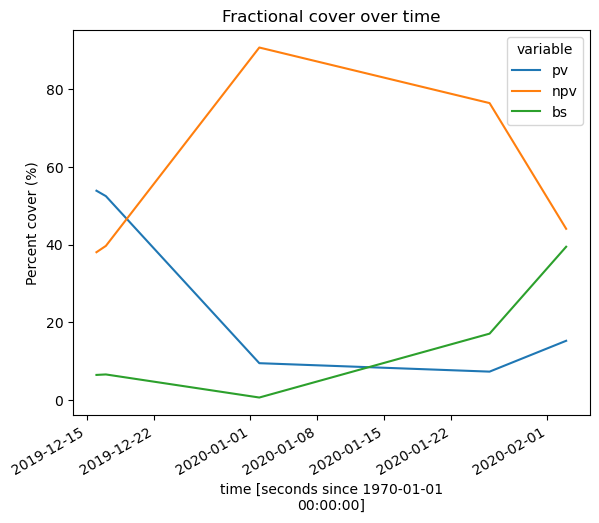

In [17]:
# Calculate average fractional cover for `bs`, `pv` and `npv` over time
fc_through_time = fc_masked[['pv', 'npv', 'bs']].mean(dim=['x', 'y'])

# Plot the changing proportions as a line graph
fc_through_time.to_array().plot.line(hue='variable', size=5)
plt.title('Fractional cover over time')
plt.ylabel('Percent cover (%)');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2023

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)